In [2]:
import copy
import shutil
import math
import os
import time

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchinfo

import utility as util

def show_image(ax, image):
    image = image / 2 + 0.5
    ax.imshow(image.numpy().transpose(1,2,0))

Create (train, test) set from dataset

In [3]:
def split_files(datadir, splitdir, classes, frac_train=0.8):
    traindir = os.path.join(splitdir, 'train')
    os.makedirs(traindir, exist_ok=True)
    testdir  = os.path.join(splitdir, 'test')
    os.makedirs(testdir,  exist_ok=True)
    
    for _class in tqdm(classes):
        classdir = os.path.join(datadir, _class)
        files    = os.listdir(classdir)
        n_train  = int(frac_train*len(files))
        trainfiles = files[:n_train]
        testfiles  = files[n_train:]
        
        for datatype, _dir, files in [('train', traindir, trainfiles), ('test', testdir, testfiles)]:
            for file in files:
                srcfile = os.path.join(classdir, file)
                dstdir = os.path.join(_dir, _class)
                os.makedirs(dstdir, exist_ok=True)
                shutil.move(srcfile, dstdir)
        
# print(os.listdir('data/caltech101/101_ObjectCategories'))
classes = ['butterfly', 'mandolin', 'mayfly', 'watch', 'inline_skate', 'ibis', 'helicopter', 'brontosaurus',
          'hawksbill', 'garfield', 'stop_sign', 'menorah', 'binocular', 'cougar_body', 'anchor', 'Faces_easy',
          'bass', 'ketch', 'car_side', 'pizza', 'ewer', 'scissors', 'lamp', 'ceiling_fan', 'wheelchair', 'platypus',
          'lobster', 'wild_cat', 'crayfish', 'camera', 'dolphin', 'windsor_chair', 'saxophone', 'revolver',
          'crocodile', 'kangaroo', 'pyramid', 'llama', 'cannon', 'octopus', 'schooner', 'pagoda', 'strawberry',
          'flamingo_head', 'crocodile_head', 'rhino', 'sea_horse', 'chair', 'beaver',
          'starfish', 'umbrella', 'buddha', 'gerenuk', 'bonsai', 'metronome', 'pigeon', 'cellphone',
          'stegosaurus', 'elephant', 'grand_piano', 'tick', 'lotus', 'euphonium', 'chandelier', 'soccer_ball',
          'cup', 'headphone', 'crab', 'joshua_tree', 'minaret', 'ferry', 'nautilus', 'electric_guitar', 'wrench',
          'Leopards', 'rooster', 'flamingo', 'dalmatian', 'stapler', 'yin_yang', 'water_lilly', 'ant', 'barrel',
          'gramophone', 'airplanes', 'snoopy', 'sunflower', 'accordion', 'cougar_face', 'scorpion', 'okapi',
          'laptop', 'panda', 'hedgehog', 'Motorbikes', 'dollar_bill', 'dragonfly', 'trilobite', 'emu', 'brain']
split_files('data/caltech101/101_ObjectCategories', 'data/caltech101', classes)

Set up data transforms

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class SquarePad:
    """
    Based on:
    https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850/3
    """
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return transforms.functional.pad(image, padding, 0, 'constant')

image_transforms = {
    'train': transforms.Compose([
            SquarePad(),
            transforms.RandomRotation(degrees=10),
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=100, scale=(0.95,1.05), ratio=(0.95, 1.05)),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5)
    ]),
    'test': transforms.Compose([
            SquarePad(),
            transforms.Resize(100),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5)              
    ])
}

Using device: cuda:0


In [4]:
folder = torchvision.datasets.ImageFolder(root='./test')
folder[0]

(<PIL.Image.Image image mode=RGB size=263x332 at 0x7F5E12E964A8>, 0)

Get dataset

In [5]:
data = {
    'train': torchvision.datasets.ImageFolder(root='./train', transform=image_transforms['train']),
    'test': torchvision.datasets.ImageFolder(root='./test', transform=image_transforms['test'])
}
## dataset attributes
# data['train'].targets # the labels of the dataset
# data['train'].classes # class names
# data['train'].class_to_idx # mapping of class name to index
assert data['train'].classes == data['test'].classes
print(f"{len(data['train'])} training samples; {len(data['test'])} testing samples")

6634 training samples; 1608 testing samples


View train set

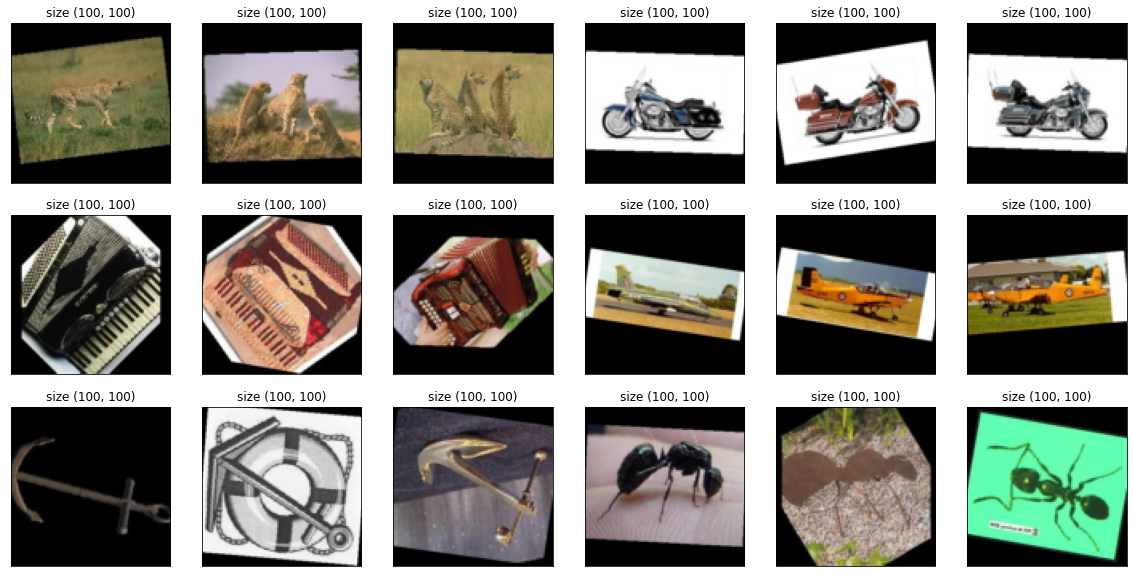

In [90]:
labels = [1, 2, 3, 4, 5, 6]#, 7, 8, 9, 10]
n_images = 3
n_labels = len(labels)
n_plots = n_labels*n_images
fig, axes = plt.subplots(n_plots // 6 + int(n_plots % 6 > 0), 6, figsize=(20, 10))
axes = axes.ravel()
idx = 0

for label in labels:
    samples = util.filter_to_sublist(lambda x: x[1] == label, data['train'], n_images)
    for s_idx, (image, label) in enumerate(samples):
        show_image(axes[idx], image)
        _, w, h = image.shape
        axes[idx].set_title(f"size ({w}, {h})")
        idx += 1

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

View test set

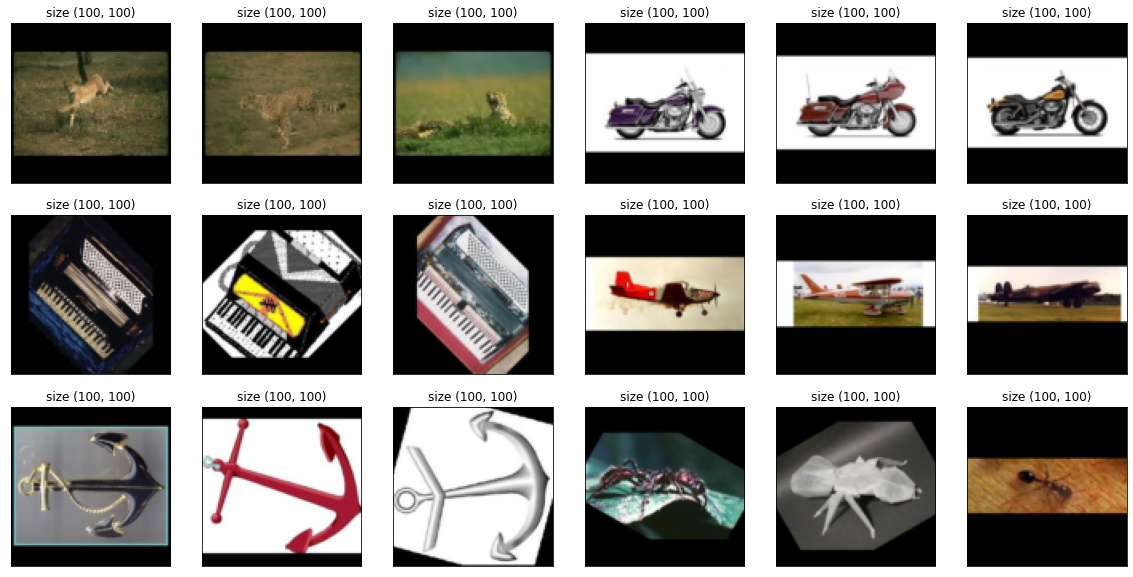

In [49]:
labels = [1, 2, 3, 4, 5, 6]#, 7, 8, 9, 10]
n_images = 3
n_labels = len(labels)
n_plots = n_labels*n_images
fig, axes = plt.subplots(n_plots // 6 + int(n_plots % 6 > 0), 6, figsize=(20, 10))
axes = axes.ravel()
idx = 0

for label in labels:
    samples = util.filter_to_sublist(lambda x: x[1] == label, data['test'], n_images)
    for s_idx, (image, label) in enumerate(samples):
        show_image(axes[idx], image)
        _, w, h = image.shape
        axes[idx].set_title(f"size ({w}, {h})")
        idx += 1

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

Get histogram of the classes

Here's the specs for sets


(100,
 array([ 25,  26,  27,  28,  28,  28,  28,  28,  28,  28,  30,  31,  32,
         32,  32,  32,  32,  33,  34,  34,  34,  35,  35,  35,  36,  36,
         36,  37,  38,  38,  38,  38,  40,  40,  40,  40,  41,  41,  42,
         43,  43,  44,  44,  44,  44,  45,  46,  46,  46,  48,  48,  48,
         48,  48,  49,  50,  51,  52,  52,  52,  52,  52,  52,  53,  54,
         54,  54,  55,  56,  56,  59,  60,  60,  61,  63,  64,  65,  66,
         68,  68,  68,  68,  69,  69,  69,  70,  71,  73,  79,  80,  80,
         86,  92,  99, 103, 160, 192, 348, 639, 640]))

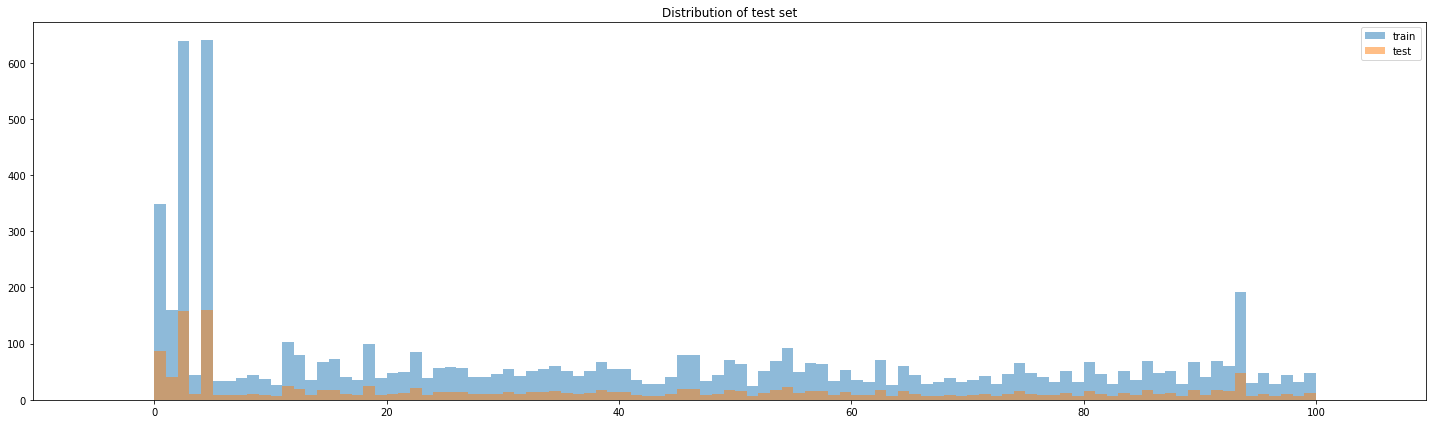

In [6]:
_data = {
    'train': torchvision.datasets.ImageFolder(root='./train', transform=transforms.ToTensor()),
    'test': torchvision.datasets.ImageFolder(root='./test', transform=transforms.ToTensor())
}

fig, ax = plt.subplots(1, 1, figsize=(20,6))
axes = [ax]

labels = _data['train'].targets
bins = range(-5,105)
axes[0].hist(labels, bins=bins, alpha=0.5, label='train')
labels = _data['test'].targets
axes[0].hist(labels, bins=bins, alpha=0.5, label='test')
axes[0].set_title("Distribution of test set")
axes[0].legend(loc='upper right')
fig.tight_layout()

labels = _data['train'].targets
counts = np.bincount(labels)
print("Here's the specs for sets")
counts.sort()
counts.size, counts # should show that many samples have ~ 

Set up data sampler and dataloader

In [6]:
args = util.AttrDict(epochs=20, print_every=50, batch_size=32,
        learning_rate=0.01)

In [7]:
def get_sampler(labels, n_samples=None, replacement=True):
    """Computes the weights for the weighted random sampler based on label distribution
    
    Based on:
    https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264/25
    """
    _, counts = np.unique(labels, return_counts=True)
    weights = 1.0 / torch.tensor(counts, dtype=torch.float)
    sample_weights = weights[labels]
    if not n_samples:
        n_samples = len(sample_weights)
    sampler = torch.utils.data.WeightedRandomSampler(sample_weights, n_samples, replacement=True)
    return sampler

trainloader = torch.utils.data.DataLoader(data['train'],
        sampler=get_sampler(data['train'].targets, n_samples=8000),
        batch_size=args.batch_size, num_workers=2)
testloader = torch.utils.data.DataLoader(data['test'],
        sampler=get_sampler(data['test'].targets, n_samples=200, replacement=False),
        batch_size=args.batch_size, num_workers=2)

print(f"Training set: {len(trainloader)} batches, {len(trainloader) * args.batch_size} samples")
print(f"Test set: {len(testloader)} batches, {len(testloader) * args.batch_size} samples")

Training set: 250 batches, 8000 samples
Test set: 7 batches, 224 samples


kangaroo soccer_ball gerenuk car_side flamingo anchor brain crayfish watch cannon kangaroo lobster car_side  bass panda bonsai okapi ceiling_fan chandelier euphonium   ant platypus kangaroo Faces_easy ceiling_fan garfield rooster flamingo_head   cup schooner pyramid ketch


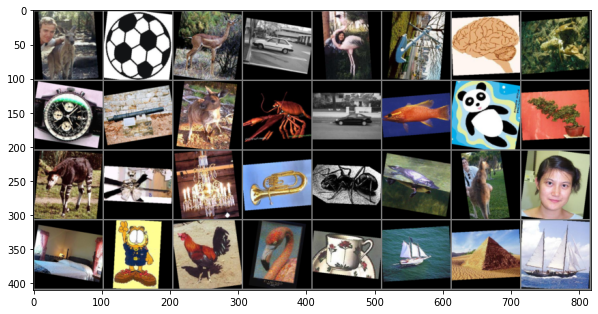

In [8]:
# functions to show an image
def imshow(img):
    # Un-normalize data.
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
# images has shape (batch size, num channels (3), hor width, ver height)
# labels has shape (batch size,)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(10, 10))
show_image(plt.gca(), torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % data['train'].classes[labels[j]] for j in range(args.batch_size)))

Declare the model

In [5]:
class Net(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.patch_size      = config.patch_size
        self.image_channels  = config.image_channels
        self.hidden_channels = config.hidden_channels
        self.output_size     = config.output_size
        self.filters         = config.filters
        try:
            self.strides  = config.strides
        except:
            self.strides  = [1 for _ in self.filters]
        try:
            self.paddings = config.paddings
        except:
            self.paddings = [0 for _ in self.filters]
        try:
            self.poolings = config.poolings
        except:
            self.poolings = [None for _ in self.filters]
        self.fc_features     = config.fc_features
        dummy = torch.ones((self.image_channels, *self.patch_size,)).unsqueeze(0) \
                * torch.tensor(float('nan'))
        conv_layers = []
        _channels = util.pairwise((self.image_channels, *self.hidden_channels,))
        for idx, ((_in_channel, _out_channel), _filter, _stride, _padding, _pool) in enumerate(
                zip(_channels, self.filters, self.strides, self.paddings, self.poolings)):
            conv = nn.Conv2d(_in_channel, _out_channel, _filter, stride=_stride, padding=_padding)
            conv_layers.append(conv)
            conv_layers.append(nn.ReLU())
            if _pool == 'max':
                pool = nn.MaxPool2d(2, 2)
                conv_layers.append(pool)
            elif _pool is None:
                pass
        self.convs = nn.Sequential(*conv_layers)
        dummy = self.convs(dummy)
        self.fc_inputs = dummy.numel()
        _features = util.pairwise((self.fc_inputs, *self.fc_features, self.output_size))
        fc_layers = []
        for idx, (_in_features, _out_features) in enumerate(_features):
            fc = nn.Linear(_in_features, _out_features)
            fc_layers.append(fc)
            fc_layers.append(nn.ReLU())
        self.fcs = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fcs(x)
        return x

In [6]:
# Print Summary of Model

base_config = util.AttrDict(
    image_channels  = 3,
    patch_size      = [100, 100],
    hidden_channels = [128, 256, 512],
    filters = [5, 3, 3],
    poolings = ['max', 'max', 'max'],
    fc_features = [1024],
    output_size = 100)

config = util.AttrDict(**base_config)

# conv 128x5x5 stride 2x2 relu maxpool conv 256x3x3 relu maxpool
# conv 512x3x3 relu maxpool full 1024 relu full 102 softmax
# Parameters: 9,977,188; (loss 1.7900; accuracy: 37.00% at 5 epochs, 32 bs, 0.01 lr)
# Plateaus around loss: 1; accuracy 45%
# based on https://github.com/marcuniq/ini_caltech101
def modify_1():
    config.strides = [2, 1, 1]
# modify_1()

# Parameters: 6,780,260; (loss 2.6066; accuracy: 22.00% at 5 epochs, 32 bs, 0.01 lr)
def modify_2():
    config.hidden_channels = [128, 256, 512, 512]
    config.filters = [5, 5, 3, 3]
    config.strides = [2, 2, 1, 1]
    config.poolings = ['max', 'max', None, 'max']
    config.paddings = [2, 2, 1, 1]
    config.fc_features = [512]
# modify_2()

# Parameters: 9,191,268; (loss 2.7147; accuracy 30.50% at 5 epochs, 32 bs, 0.01 lr)
# Plateaus around loss: 1.5; accuracy: 35%
def modify_3():
    config.hidden_channels = [128, 256, 512, 512]
    config.filters = [5, 5, 3, 3]
    config.strides = [2, 2, 1, 1]
    config.poolings = ['max', 'max', None, 'max']
    config.paddings = [2, 2, 1, 1]
    config.fc_features = [1024]
modify_3()

# Reproduce VGG net?
def modify_4():
    config.hidden_channels = [64, 128, 256, 256, 512, 512]
    config.filters = [5, 5, 3, 3, 3, 3, 3, 3]
    config.poolings = ['max', 'max', None, 'max', None, 'max']
    config.paddings = [0, 0, 1, 1, 1, 1, 1]
    config.fc_features = [512]
# modify_4()

net = Net(config).to(device)
col_names = ("input_size", "output_size", "num_params", "kernel_size")#, "mult_adds",)
torchinfo.summary(net, input_size=(1, 3, 100, 100), col_names=col_names, col_width=18)

/home/fireofearth/.local/miniconda3/envs/ml/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


NameError: name 'device' is not defined

[(3, 128), (128, 256), (256, 512), (512, 512)]
[(4608, 1024), (1024, 100)]



Test accuracy: 4.50%



Test accuracy: 12.00%



Test accuracy: 13.50%



Test accuracy: 22.00%



Test accuracy: 23.50%



Test accuracy: 26.50%



Test accuracy: 34.00%



Test accuracy: 33.50%



Test accuracy: 36.50%



Test accuracy: 40.00%



Test accuracy: 35.00%



Test accuracy: 30.00%



Test accuracy: 35.00%



Test accuracy: 24.50%



Test accuracy: 34.50%



Test accuracy: 34.00%



Test accuracy: 28.00%



Test accuracy: 39.00%



Test accuracy: 34.00%



Test accuracy: 36.50%
Done.
Training time took 249.1967203617096 seconds


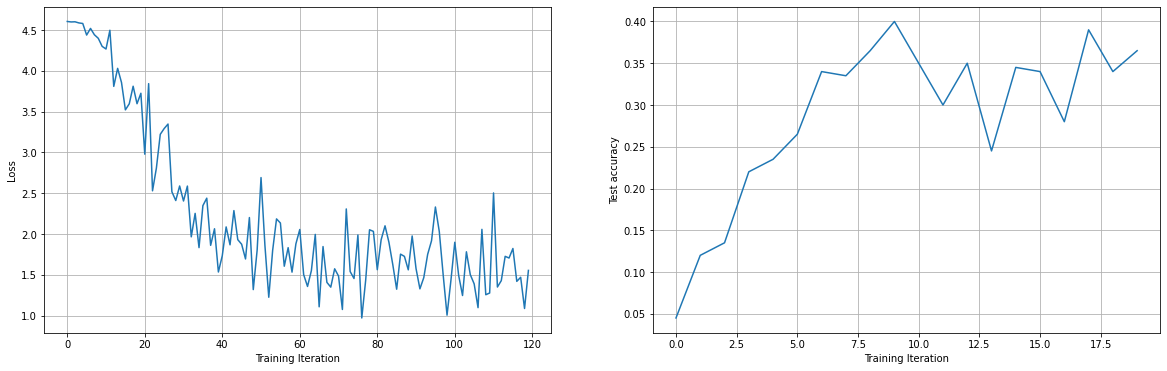

In [100]:
loss_over_time = []
acc_over_time = []
def train(net, args, trainloader, testloader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.learning_rate, momentum=0.9)
#     optimizer = optim.Adam(net.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
#     scheduler = None
    
    for epoch in range(1, args.epochs + 1):
        prefix = f"Training Epoch {epoch}: "
        pbar = tqdm(trainloader, desc=prefix, 
                dynamic_ncols=True, leave=True, position=0)
        
        if epoch == 6:
            for g in optimizer.param_groups:
                g['lr'] = 0.001
        if epoch == 7:
            for g in optimizer.param_groups:
                g['lr'] = 0.0001
        for iteration, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if iteration % args.print_every == 0 or iteration == len(trainloader)-1:
                pbar.set_description("Training epoch {} (loss {:9.4f}): ".format(epoch, loss.item()))
                pbar.update()
                loss_over_time.append(loss.item())
        correct = 0
        total = 0
        with torch.no_grad():
            net.eval()
            prefix = f"Evaluating: "
            for inputs, labels in tqdm(testloader, desc=prefix,
                        dynamic_ncols=True, leave=True, position=0):
                inputs, labels = inputs.to(device), labels.to(device)
                # calculate outputs by running images through the network
                outputs = net(inputs)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            net.train()
        print("Test accuracy: {:1.2%}".format(correct / total))
        acc_over_time.append(correct / total)
        if scheduler:
            scheduler.step()
    print("Done.")

net = Net(config).to(device)
should_create_new_instance = True
if should_create_new_instance:
    start = time.time()
    train(net, args, trainloader, testloader)
    end = time.time()
    print(f"Training time took {end - start} seconds")
    torch.save(net.state_dict(), './models/caltech101_net.pth')
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    axes = axes.ravel()
    axes[0].plot(range(len(loss_over_time)), loss_over_time)
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("Training Iteration")
    axes[0].grid()
    axes[1].plot(range(len(acc_over_time)), acc_over_time)
    axes[1].set_ylabel("Test accuracy")
    axes[1].set_xlabel("Training Iteration")
    axes[1].grid()
else:
    net.load_state_dict(torch.load('./models/caltech101_net.pth'))

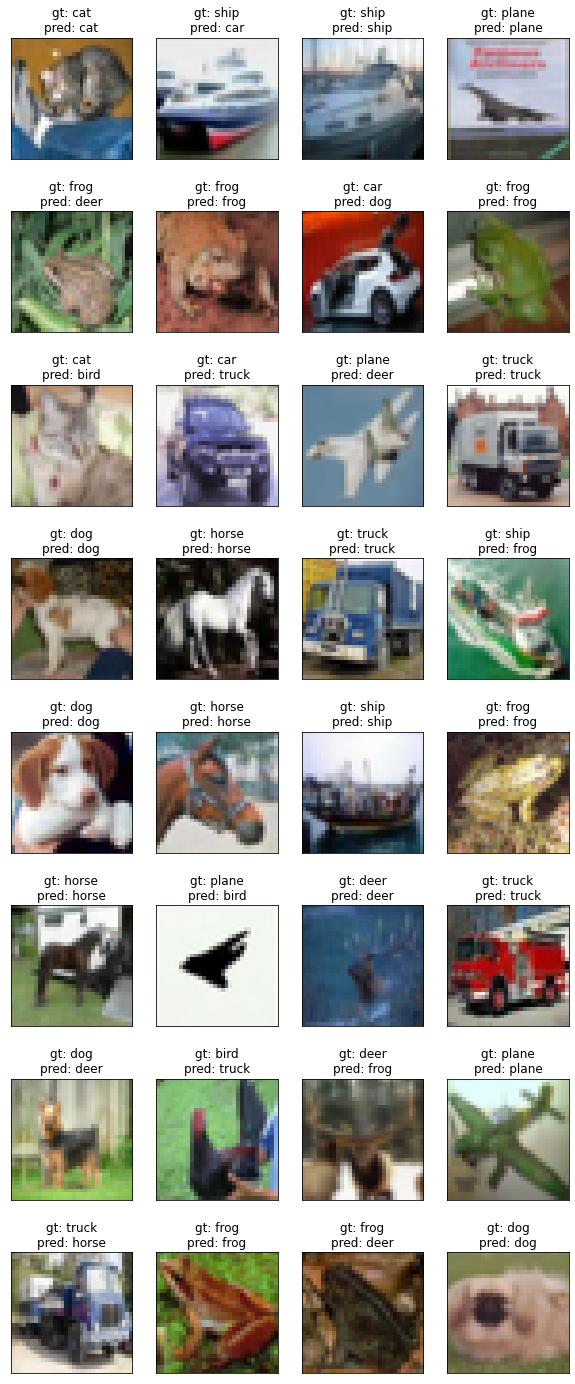

In [143]:
dataiter = iter(testloader)
images, labels = dataiter.next()

_images = images.to(device)
outputs = net(_images)
_, predicted = torch.max(outputs, 1)

# print images
# imshow(torchvision.utils.make_grid(images))
# get labels
ground_truth = [classes[labels[j]] for j in range(args.batch_size)]
predictions = [classes[predicted[j]] for j in range(args.batch_size)]

df = pd.DataFrame({
    'GroundTruth': ground_truth,
    'Prediction': predictions
})

images = images.numpy()
n_rows = args.batch_size // 4 + int((args.batch_size % 4) > 0)
fig, axes = plt.subplots(n_rows, 4, figsize=(10, 25))
axes = axes.ravel()
for idx, image in enumerate(images):
    image = image / 2 + 0.5
    image = image.transpose((1, 2, 0))
    axes[idx].imshow(image)
    title = "gt: {}\npred: {}".format(df.at[idx, 'GroundTruth'], df.at[idx, 'Prediction'])
    axes[idx].set_title(title)
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [49]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    prefix = f"Evaluating: "
    for images, labels in tqdm(testloader, desc=prefix,
                dynamic_ncols=True, leave=True, position=0):
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 54 %


In [50]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    net.eval()
    prefix = f"Evaluating: "
    for images, labels in tqdm(testloader, desc=prefix,
                dynamic_ncols=True, leave=True, position=0):
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
    net.train()


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))


Accuracy for class plane is: 66.2 %
Accuracy for class car   is: 72.9 %
Accuracy for class bird  is: 30.7 %
Accuracy for class cat   is: 11.5 %
Accuracy for class deer  is: 61.6 %
Accuracy for class dog   is: 57.8 %
Accuracy for class frog  is: 61.7 %
Accuracy for class horse is: 62.8 %
Accuracy for class ship  is: 56.7 %
Accuracy for class truck is: 62.0 %
